# 多项逻辑回归

也叫“Softmax回归”，因为拓展[逻辑回归](./逻辑回归.ipynb)到多个类别（而不止两类）。

给定：

- 数据集合 $\{(x^{(1)},y^{(1)}),\ldots,(x^{(m)},y^{(m)})\}$
- 每个 $x^{(i)}$ 都是 $d$ 维向量 $x^{(i)}=(x^{(i)},\ldots,x^{(i)})$
- 而 $y^{(i)}$ 是 $x^{(i)}$ 的目标变量
  - 例如 $K=3$ 类则有 $y^{(i)} \in \{0,1,2\}$

凡Softmax回归模型都有如下特征：

- 每个类别都有一个分离的实值权重向量 $w=(w^{(1)},\ldots,w^{(d)})$
  - 权重向量典型地以行保存在权重矩阵
- 每个类别都有一个分离的实值偏置 $b$
- 以 $softmax$ 函数作为激活函数
- 互熵（*cross-entropy*）损失函数

训练多项逻辑回归模型，首先是初始化参数，随后重复指定次数的训练迭代或直到参数收敛。

---

- 第一步

    初始化权重矩阵和偏置值为零（或小的随机数）

- 第二步

    每个类 $k$ 计算输入特性和该类权重向量的线性组合，就是说，一个训练样本计算一个类的得分，对类 $k$ 和输入向量 $x^{(i)}$ 有： $$score_k(x^{(i)})=w_k^T \cdot x^{(i)}$$
    
    其中 $\cdot$ 是点积、 $w_{(k)}$ 是类 $k$ 的权重向量，通过向量话和广播可以并行计算所有类别和训练样本的得分： $$scores=X \cdot W^T + b$$
    
    这里 $X$ 是 $(n_{samples},n_{features})$ 形状的矩阵，保有全部训练样本， $W$ 是 $(n_{classes},n_{features})$ 形状的矩阵，保有每类的权重向量

- 第三步

    应用softmax激活函数，把得分转换成概率
    
    属于类 $k$ 的输入向量 $x^{(i)}$ 的概率按下式计算： $$ \hat p_k(x^{(i)})=\frac{\exp(score_k(x^{(i)}))}{\sum_{j=1}^k\exp(score_j(x^{(i)}))}$$
    
    同样对全部类别和所有训练样本通过向量话一次性执行这步，模型预测 $x^{(i)}$ 的类别则简单的对应最高的概率对应的类

- 第四步

    计算整个训练集合的成本，就是为了让模型有高的目标类别预测概率
    
    可以通过互熵损失函数来实现： $$J(W,b)=-\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^k\Big[y_k^{(i)}\log(\hat p_k^{(i)})\Big]$$
    
    该公式中，所有目标标签都是“独热码（*one-hot encoded*）”，因此 $y_k^{(i)}$ 是 $1$ 则 $x^{(i)}$ 的目标类别是 $k$ ，否则 $y_k^{(i)}$ 是 $0$

- 第五步

    计算关于每个权重向量和偏置的成本函数的梯度，详情见[关于Softmax归回的成本函数推导过程](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/)
    
    类别 $k$ 的通式如下： $$\nabla_{w_k}J(W,b)=\frac{1}{m}\sum_{i=1}^mx^{(i)}\Big[\hat p_k^{(i)} - y_k^{(i)}\Big]$$
    
    对于偏置，输入 $x^{(i)}$ 将给出 $1$ （*for the biases, the inputs $x^{(i)}$ will be given 1.*）

- 第六步

    为每个类别 $k$ 更新权重和偏置： $$w_k=w_k - \eta \nabla w_kJ$$ $$b_k=b_k - \eta \nabla b_kJ$$
    
    这里的 $\eta$ 是学习率

In [11]:
from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

## 数据集合

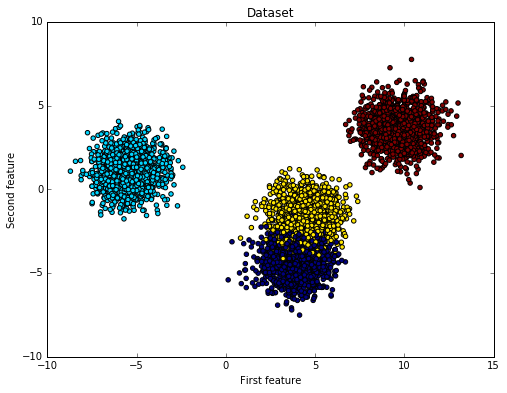

In [12]:
X, y_true = make_blobs(centers=4, n_samples=5000)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y_true)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [13]:
# 重塑目标获取形状为(n_samples, 1)的列向量
y_true = y_true[:, np.newaxis]

# 把数据分割为训练集合和测试集合
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

print "Shape X_train:", X_train.shape
print "Shape y_train:", y_train.shape
print "Shape X_test:", X_test.shape
print "Shape y_test:", y_test.shape

Shape X_train: (3750L, 2L)
Shape y_train: (3750L, 1L)
Shape X_test: (1250L, 2L)
Shape y_test: (1250L, 1L)


## Softmax回归类

In [14]:
class SoftmaxRegression:
    def __init__(self): pass
    def train(self, X, y_true, n_classes, n_iters=10, learning_rate=0.1):
        '''在给定训练数据上训练多项逻辑回归模型'''
        self.n_samples, n_features = X.shape
        self.n_classes = n_classes
        
        self.weights = np.random.rand(self.n_classes, n_features)
        self.bias = np.zeros((1, self.n_classes))
        all_losses = []
        
        for i in range(n_iters):
            scores = self.compute_scores(X)
            probs = self.softmax(scores)
            y_predict = np.argmax(probs, axis=1)[:, np.newaxis]
            y_one_hot = self.one_hot(y_true)
            
            loss = self.cross_entropy(y_one_hot, probs)
            all_losses.append(loss)
            
            dw = (1.0 / self.n_samples) * np.dot(X.T, (probs - y_one_hot))
            db = (1.0 / self.n_samples) * np.sum(probs - y_one_hot, axis=0)
            
            self.weights = self.weights - learning_rate * dw.T
            self.bias = self.bias - learning_rate * db
            
            if i%100 == 0:
                print "Iteratioin number: {i}, loss: {loss}".format(i=i, loss=np.round(loss, 4))
        
        return self.weights, self.bias, all_losses
    def predict(self, X):
        '''
        预测样本的类别标签
        参数：形状是(n_samples, n_features)的矩阵
        返回值：形状是(n_samples, 1)的矩阵（预测的类别）
        '''
        scores = self.compute_scores(X)
        probs = self.softmax(scores)
        
        return np.argmax(probs, axis=1)[:, np.newaxis]
    def softmax(self, scores):
        '''
        把预测得分矩阵转换成概率矩阵
        参数：形状是(n_samples, n_classes)的矩阵（未标准化的得分）
        返回值：形状是(n_samples, n_classes)的矩阵（概率）
        '''
        exp = np.exp(scores)
        sum_exp = np.sum(exp, axis=1, keepdims=True)
        softmax = exp / sum_exp
        
        return softmax
    def compute_scores(self, X):
        '''
        计算样本类别得分元组
        参数：形状是(n_samples, n_features)的矩阵
        返回值：形状是(n_samples, n_classes)的矩阵
        '''
        return np.dot(X, self.weights.T) + self.bias
    def cross_entropy(self, y_true, scores):
        loss = - (1.0 / self.n_samples) * np.sum(y_true * np.log(scores))
        return loss
    def one_hot(self, y):
        '''把标签向量转换成独热码矩阵'''
        one_hot = np.zeros((self.n_samples, self.n_classes))
        one_hot[np.arange(self.n_samples), y.T] = 1
        
        return one_hot

## 初始化并训练模型

Iteratioin number: 0, loss: 4.1531
Iteratioin number: 100, loss: 0.1913
Iteratioin number: 200, loss: 0.1574
Iteratioin number: 300, loss: 0.1438
Iteratioin number: 400, loss: 0.1362
Iteratioin number: 500, loss: 0.1313
Iteratioin number: 600, loss: 0.1277
Iteratioin number: 700, loss: 0.1249
Iteratioin number: 800, loss: 0.1227
Iteratioin number: 900, loss: 0.1209


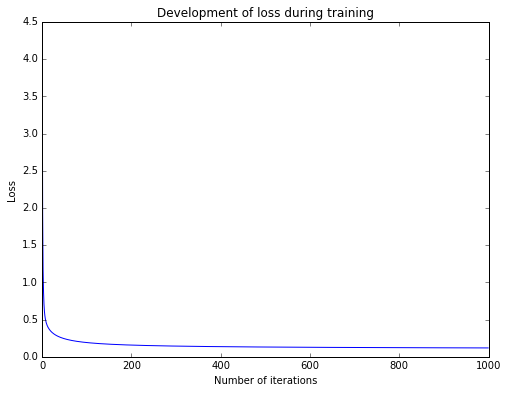

In [17]:
regression = SoftmaxRegression()
w_trained, b_trained, loss = regression.train(X_train, y_train, learning_rate=0.1, n_iters=1000, n_classes=4)

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(1000), loss)
plt.title("Development of loss during training")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

## 测试模型

In [19]:
n_test_samples, _ = X_test.shape
y_predict = regression.predict(X_test)

print "Classification accuracy on test set: {0}%%".format((np.sum(y_predict == y_test) / float(n_test_samples) * 100))

Classification accuracy on test set: 95.12%%
